In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize()
import multiprocessing
import numpy as np
import os
from collections import Counter, defaultdict
import itertools
import sys 
sys.path.append("..") 

%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from utils import prinT
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
k_list = [8, 8, 13, 25, 19, 18, 23]
start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']
ref_start_year = 2010
ref_end_year = 2021

# Functions for processing time series

In [4]:
def filter_nan_in_middle(x):
    val_list = x.to_list()
    
    start_idx = -1
    end_idx = -1
    nan_in_middle = False
    for i in range(0, len(val_list)):
        if not np.isnan(val_list[i]):
            start_idx = i
            break
    for i in range(len(val_list)-1, -1, -1):
        if not np.isnan(val_list[i]):
            end_idx = i
            break
    for i in range(start_idx, end_idx):
        if np.isnan(val_list[i]):
            nan_in_middle = True
            break
    if start_idx == end_idx:
        len_of_1 = True
    else :
        len_of_1 = False
    return nan_in_middle, len_of_1, start_idx, end_idx

# Generate a dataframe which contains periodical's global semantic change

In [10]:
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import paired_distances

global_semantic_change_df = pd.DataFrame(columns=['VID'])
col_name_list = ['semantic_change_1960s', 
                 'semantic_change_1970s', 
                 'semantic_change_1980s',
                 'semantic_change_1990s',
                 'semantic_change_2000s',
                 'semantic_change_2010s']

for i in range(0, 6):
    old_start_year, old_end_year = start_year_list[i], end_year_list[i]
    new_start_year, new_end_year = start_year_list[i+1], end_year_list[i+1]
    print("-----------------------")
    prinT("start comparing {}-{} with the {}-{}".format(old_start_year, old_end_year, new_start_year, new_end_year))

    old_wv = model.load_wv(old_start_year, old_end_year, 100, 10)
    new_wv = model.load_wv(new_start_year, new_end_year, 100, 10)
    
    old_VIDs = old_wv.index_to_key
    new_VIDs = new_wv.index_to_key
    shared_VIDs = list(set(old_VIDs) & set(new_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    old_idx = [old_wv.get_index(VID) for VID in shared_VIDs]
    new_idx = [new_wv.get_index(VID) for VID in shared_VIDs]
    
    old_vectors = old_wv.get_normed_vectors()[old_idx]
    new_vectors = new_wv.get_normed_vectors()[new_idx]
    
    prinT("start aligning...")
    R, sca = orthogonal_procrustes(old_vectors, new_vectors)
    aligned_old_vectors = np.dot(old_vectors, R)
    prinT("finish. start compute cosine distance...")
    # cs = np.diagonal(cosine_similarity(aligned_tar_vectors, ref_vectors))
    dist =  paired_distances(aligned_old_vectors, new_vectors, metric='cosine')
    prinT("finish")

    tar_dist_df = pd.DataFrame({'VID': shared_VIDs,
                                col_name_list[i]: dist})
    global_semantic_change_df = global_semantic_change_df.merge(tar_dist_df, on='VID', how='outer')
    global_semantic_change_df['total_semantic_change_'+new_start_year+'s'] = global_semantic_change_df[col_name_list[0:i+1]].sum(axis=1)

-----------------------
2024-01-17 23:36:50 -- start comparing 1950-1959 with the 1960-1969
2024-01-17 23:36:50 -- start loading word vectors...
2024-01-17 23:36:50 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-17 23:36:50 -- start loading word vectors...
2024-01-17 23:36:50 -- word vectors loaded, and its shape is: (3116, 100)
2024-01-17 23:36:50 -- the number of shared VIDs between this two decades: 1500
2024-01-17 23:36:50 -- start aligning...
2024-01-17 23:36:50 -- finish. start compute cosine distance...
2024-01-17 23:36:50 -- finish
-----------------------
2024-01-17 23:36:50 -- start comparing 1960-1969 with the 1970-1979
2024-01-17 23:36:50 -- start loading word vectors...
2024-01-17 23:36:50 -- word vectors loaded, and its shape is: (3116, 100)
2024-01-17 23:36:50 -- start loading word vectors...
2024-01-17 23:36:50 -- word vectors loaded, and its shape is: (5686, 100)
2024-01-17 23:36:50 -- the number of shared VIDs between this two decades: 2809
2024-01-17 23

In [11]:
# Labelling
global_semantic_change_df.loc[:,'venue_name'] = global_semantic_change_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
# Using the lastes decade's labels
VID_labele_dict = model.load_VID_labeled(2010, 2021, 100, 10)
global_semantic_change_df['scopus_label'] = global_semantic_change_df.VID.map(lambda x: VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                                                            else np.nan)

2024-01-17 23:37:24 -- start loading VID_labeled...
2024-01-17 23:37:24 -- finish.


In [12]:
# incorrect venues in MAG
corrupted_venue_name_list = ['Japanese Journal of Pharmacology', 
                             'Journal of Computers',
                             'Journal of Algorithms',
                             'Journal of Agricultural Engineering Research',
                             'Sozial-und Praventivmedizin',
                             'Scientia Forestalis',
                             'Interpretation',
                             'Genes',
                             'Protein Science',
                             'Hospital Medicine',
                             'Immunotechnology',
                             'Journal of Ayurveda and Integrative Medicine',
                             'Versus',
                             'Tradition',
                             'ACM Transactions on Cyber-Physical Systems',
                             'Journal of Biomedical Engineering',
                             'Antibiotics and Chemotherapy',
                             'Social Work',
                             'Production Journal',
                             'Insight',
                             'Sats',
                             'English',
                             'Leonardo',
                             'The Forum',
                             'Chemical Industry',
                             'The American review of respiratory disease',
                             'Chemistry & Industry',
                            ]

In [13]:
# Filtering
global_semantic_change_df = global_semantic_change_df[~(global_semantic_change_df.venue_name.isin(corrupted_venue_name_list))]
global_semantic_change_df[['nan_in_middle', 
                          'len_of_1', 
                          'start_idx', 
                          'end_idx']] = global_semantic_change_df[col_name_list].apply(filter_nan_in_middle, axis=1, result_type='expand')
# Make sure that each time series never interrupts and has a value for the lastest decade
global_semantic_change_df = global_semantic_change_df[(global_semantic_change_df.nan_in_middle==False) & (global_semantic_change_df.end_idx==5)]

In [14]:
global_semantic_change_df

,VID,semantic_change_1960s,total_semantic_change_1960s,semantic_change_1970s,total_semantic_change_1970s,semantic_change_1980s,total_semantic_change_1980s,semantic_change_1990s,total_semantic_change_1990s,semantic_change_2000s,total_semantic_change_2000s,semantic_change_2010s,total_semantic_change_2010s,venue_name,scopus_label,nan_in_middle,len_of_1,start_idx,end_idx
0,2.785285e+06,0.201948,0.201948,0.245187,0.447135,0.175657,0.622792,0.232991,0.855783,0.169536,1.025318,0.206745,1.232063,The Journal of Comparative Neurology,Neuroscience,False,False,0,5
2,2.756444e+09,0.229495,0.229495,0.296994,0.526489,0.358100,0.884589,0.354083,1.238672,0.556375,1.795047,0.715037,2.510084,Advances in internal medicine,NaN,False,False,0,5
3,1.709670e+08,0.254430,0.254430,0.352413,0.606843,0.309861,0.916704,0.307178,1.223882,0.214223,1.438105,0.258660,1.696765,American Journal of Epidemiology,Medicine,False,False,0,5
4,1.241662e+08,0.185459,0.185459,0.235249,0.420708,0.291455,0.712162,0.283571,0.995733,0.306676,1.302409,0.332085,1.634494,Quarterly Journal of Mechanics and Applied Mathematics,Mathematics,False,False,0,5
5,2.764775e+09,0.148245,0.148245,0.246153,0.394398,0.329139,0.723537,0.354949,1.078486,0.290380,1.368866,0.253993,1.622859,Journal of the Geological Society of Japan,Earth and Planetary Sciences,False,False,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27043,2.764439e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245568,0.245568,Bulgarian Journal of Veterinary Medicine,Veterinary,False,True,5,5
27044,2.898526e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.271480,0.271480,EMC - AKOS - Trattato di Medicina,NaN,False,True,5,5
27045,2.010644e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.195265,0.195265,European Journal of Preventive Cardiology,Medicine,False,True,5,5
27046,1.125908e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282606,0.282606,Journal of Transport and Land Use,Social Sciences,False,True,5,5


# Plot single periodical's local semantic change in every decade

In [15]:
abbr_dict = {'Nature': 'Nature',
             'Philosophical Transactions of the Royal Society B': 'Proc. R. Soc. B',
             'Quarterly Journal of Economics': 'QJE', 
             'Cognitive Science': 'Cogn Sci.',
             'The Imaging Science Journal': 'Imaging Sci. J.',
              }

<Figure size 1800x1200 with 0 Axes>

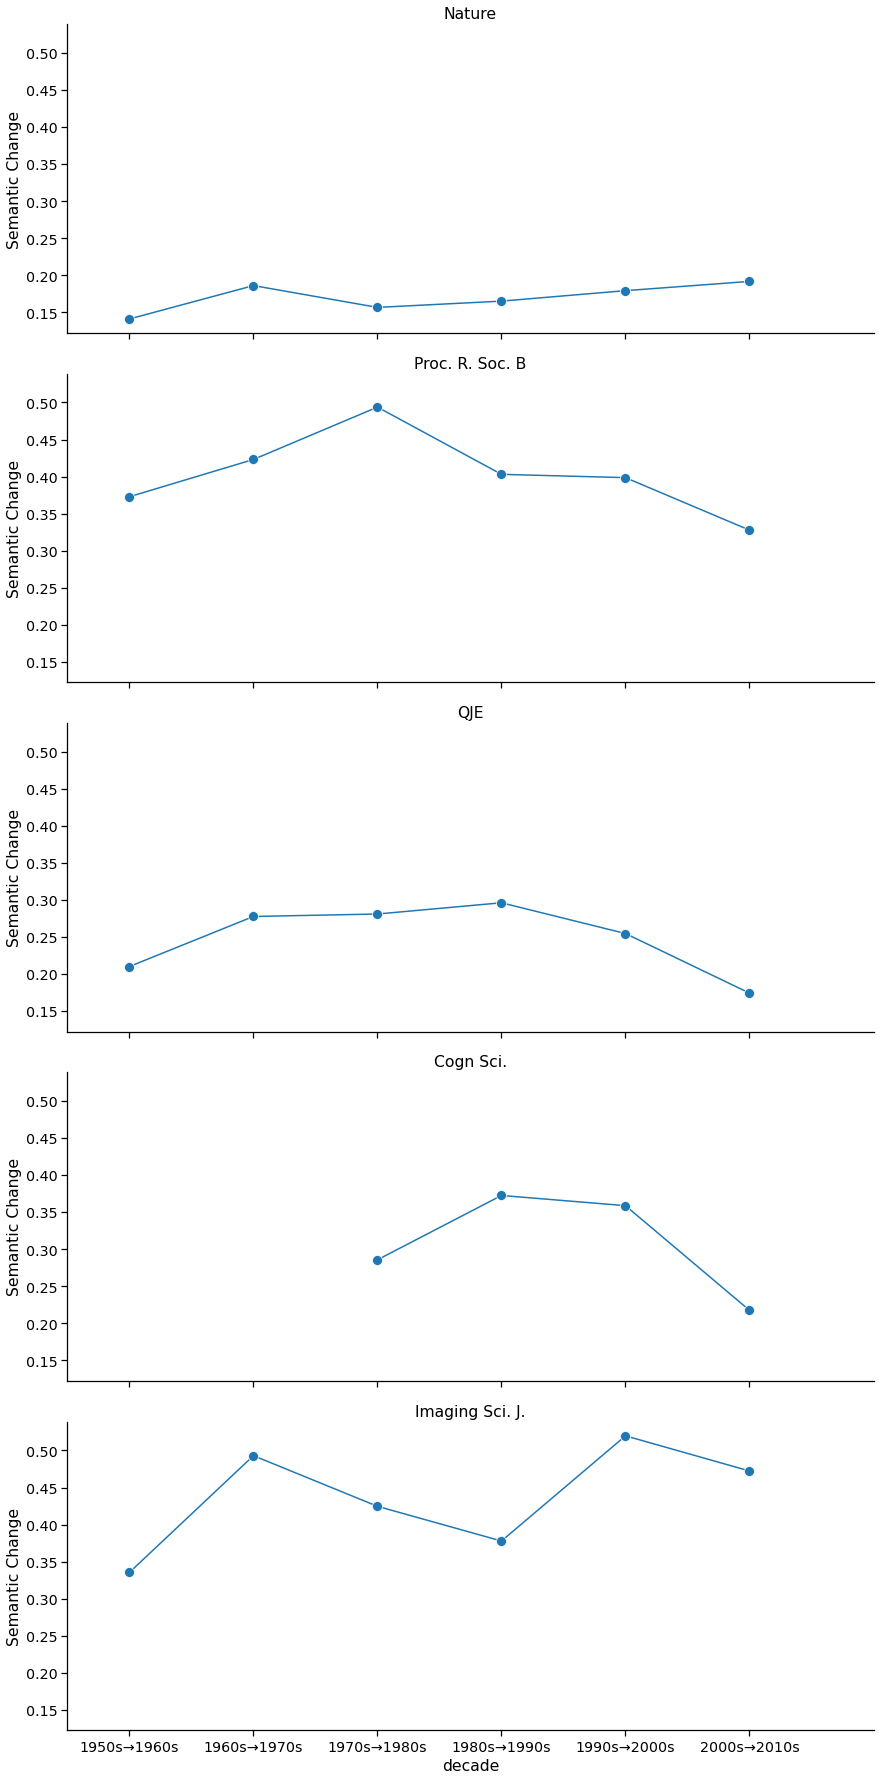

In [16]:
global_semantic_change_df_rename = global_semantic_change_df[global_semantic_change_df.venue_name.isin(abbr_dict.keys())].copy()
global_semantic_change_df_rename.venue_name = global_semantic_change_df_rename.venue_name.replace(abbr_dict)
global_semantic_change_df_rename = global_semantic_change_df_rename[['semantic_change_1960s',
                                                                   'semantic_change_1970s', 
                                                                   'semantic_change_1980s',
                                                                   'semantic_change_1990s',
                                                                   'semantic_change_2000s',
                                                                   'semantic_change_2010s',
                                                                   'venue_name']].rename(columns={'semantic_change_1960s':'semantic_change_1950s→1960s',
                                                                                                  'semantic_change_1970s':'semantic_change_1960s→1970s', 
                                                                                                  'semantic_change_1980s':'semantic_change_1970s→1980s', 
                                                                                                  'semantic_change_1990s':'semantic_change_1980s→1990s', 
                                                                                                  'semantic_change_2000s':'semantic_change_1990s→2000s', 
                                                                                                  'semantic_change_2010s':'semantic_change_2000s→2010s', 
                                                                                                 })
global_semantic_change_df_wide = pd.wide_to_long(global_semantic_change_df_rename,
                                                stubnames=['semantic_change'],
                                                suffix='.+',
                                                sep='_',
                                                i = ['venue_name'],
                                                j = 'decade')

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    g1 = sns.relplot(data=global_semantic_change_df_wide,
                    x='decade', y='semantic_change',
                    legend=False,
                    row='venue_name', row_order=abbr_dict.values(), aspect=2.5, facet_kws={'xlim':(-0.5,6)},
                    kind='line', marker='o', markersize=10)
    g1.tick_params(axis='both', bottom='on',left='on')

    g1.set_titles("{row_name}")
    g1.set_ylabels('Semantic Change')

In [17]:
g1.savefig('single_periodical_global_semantic_change.pdf', 
          dpi = 300, 
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')

# Plot the distribution of periodicals' total semantic change 

In [18]:
abbr_dict = {# 1950s
             'CA: A Cancer Journal for Clinicians':'CA: Cancer J. Clin.',
             'Quarterly Journal of Economics': 'QJE', 
             'Econometrica': 'Econometrica', 
             'Psychological Bulletin': 'Psychol. Bull.',
             'Chemical Reviews': 'Chem. Rev.',
             'JAMA': 'JAMA',
             'Science': 'Science',
             'Nature': 'Nature',
             'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
             'Physical Review Letters': 'PRL',
             'The New England Journal of Medicine': 'NEJM',
             'American Sociological Review': 'ASR',
             'Annals of Mathematics':'Ann. Math.',
             'The Lancet': 'Lancet',
             'BMJ': 'BMJ',
             'Philosophical Transactions of the Royal Society B': 'Proc. R. Soc. B',
    
             # 1960s
             'Atmosphere':'Atmosphere',
             'Language Learning': 'Lang. Learn.',
             'Automatica': 'Automatica',
             'Carbon':'Carbon',
             'Stanford Law Review': 'SLR',
             'Computing': 'Computing',
             'Journal of Applied Crystallography': 'J. Appl. Crystallogr.',
             'Ultrasonics': 'Ultrasonics',
             'IEEE Transactions on Nuclear Science': 'IEEE Trans Nucl Sci',
             'IEEE Transactions on Biomedical Engineering': 'IEEE. Trans. Biomed. Eng.',
             'Pattern Recognition': 'Pattern Recognit.',
             'Physics Letters B': 'PLB',
             'Journal of Financial and Quantitative Analysis': 'JFQA',
                
             # 1970s
             'Studies in Second Language Acquisition':'Stud. Second Lang. Acquis.',
             'Linguistic Inquiry': 'Linguist. Inq.',
             'European Journal of Political Research': 'EJPR',
             'Accounting Organizations and Society': 'Account. Organ. Soc.',
             'Clinical Infectious Diseases': 'Clin. Infect. Dis.',
             'Economic Analysis and Policy': 'Econ Anal Policy',
             'Research Policy': 'Res. Policy',
             'Gene': 'Gene',
             'Pain': 'Pain',
             'Social Networks': 'Soc. Netw.',
             'Life sciences in space research': 'Life Sci Space Res',
             'Computational Biology and Chemistry': 'Comput Biol Chem',
             'Civil Engineering': 'C.E.J',
             'Journal of Biosciences': 'J. Biosci.',
             'Cell': 'Cell',
    
             # 1980s
             'Applied Linguistics':'Appl. Linguist.',
             'Journal of Accounting and Economics': 'J. Account. Econ.',
             'Journal of Accounting and Public Policy': 'JAPP',
             'Journal of Physics: Condensed Matter': 'J. Phys. Condens. Matter',
             'Transport Reviews': 'Transp. Rev.',
             'European Management Journal': 'EMJ',
             'International Journal of Remote Sensing': 'Int. J. Remote Sens.',
             'Stem Cells': 'Stem Cells',
             'Journal of Chemometrics': 'J. Chemom.',
             'Bioelectromagnetics': 'Bioelectromagnetics',
             'neural information processing systems': 'NeurIPS',
             'IEEE Transactions on Medical Imaging': 'IEEE TMI',

             # 1990s
             'The Accounting Review': 'Account. Rev.',
             'Human Resource Management Journal': 'Hum. Resour. Manag. J.',
             'Cancer Cell': 'Cancer Cell',
             'IEEE Transactions on Applied Superconductivity': 'IEEE TAS',
             'Cell Research': 'Cell Res.',
             'the web conference': 'TheWebConf',
             'knowledge discovery and data mining': 'KDD',
             'empirical methods in natural language processing': 'EMNLP',
             'Materials': 'Materials',
             'Sensors': 'Sensor',
             'Complexity': 'Complexity',

             # 2000s
             'PLOS ONE': 'PLOS ONE',
             'Nature Reviews Immunology': 'Nat. Rev. Immunol.',
             'Nature Materials': 'Nat. Mater',
             'Lancet Oncology': 'Lancet Oncol.',
             'Nature Photonics': 'Nat. Photonics',
             'Obesity': 'Obesity',
             'Nature Chemical Biology': 'Nat. Chem. Biol.',
             'IEEE Transactions on Industrial Informatics': 'IEEE TII',
             'BMC Research Notes': 'BMC Res. Notes',
            }

display(global_semantic_change_df[(global_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(global_semantic_change_df.start_idx==0)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(global_semantic_change_df[(global_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(global_semantic_change_df.start_idx==1)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(global_semantic_change_df[(global_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(global_semantic_change_df.start_idx==2)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(global_semantic_change_df[(global_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(global_semantic_change_df.start_idx==3)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(global_semantic_change_df[(global_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(global_semantic_change_df.start_idx==4)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(global_semantic_change_df[(global_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(global_semantic_change_df.start_idx==5)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))

,venue_name,total_semantic_change_2010s
77,Philosophical Transactions of the Royal Society B,2.418914
511,Chemical Reviews,1.960168
565,CA: A Cancer Journal for Clinicians,1.871436
497,Annals of Mathematics,1.636338
605,Econometrica,1.630679
1117,American Sociological Review,1.624706
1325,Psychological Bulletin,1.623402
374,Quarterly Journal of Economics,1.494200
1320,Proceedings of the National Academy of Sciences of the United States of America,1.317172
193,JAMA,1.259457


,venue_name,total_semantic_change_2010s
2145,Journal of Applied Crystallography,2.027200
2665,Ultrasonics,1.922738
1677,Carbon,1.873705
1639,Stanford Law Review,1.822162
2401,Pattern Recognition,1.730024
2752,Computing,1.657094
1552,IEEE Transactions on Nuclear Science,1.531093
2526,IEEE Transactions on Biomedical Engineering,1.462750
2463,Automatica,1.381422
2353,Language Learning,1.373022


,venue_name,total_semantic_change_2010s
3986,Civil Engineering,1.568384
5157,Journal of Biosciences,1.537606
4159,Economic Analysis and Policy,1.517412
3012,Computational Biology and Chemistry,1.457197
3270,Social Networks,1.427054
5418,Research Policy,1.369423
4761,Accounting Organizations and Society,1.342057
4733,European Journal of Political Research,1.098556
3880,Pain,1.079055
4460,Linguistic Inquiry,1.059814


,venue_name,total_semantic_change_2010s
6090,Journal of Chemometrics,1.142478
6200,Bioelectromagnetics,0.978822
8791,Stem Cells,0.921842
6496,Transport Reviews,0.864074
6020,IEEE Transactions on Medical Imaging,0.843859
6350,neural information processing systems,0.842752
8290,Journal of Accounting and Public Policy,0.814887
5875,International Journal of Remote Sensing,0.794525
7969,European Management Journal,0.755268
7095,Journal of Accounting and Economics,0.739944


,venue_name,total_semantic_change_2010s
14253,Complexity,0.879340
9899,Materials,0.862286
10661,Sensors,0.767063
14188,IEEE Transactions on Applied Superconductivity,0.750596
14290,the web conference,0.593321
14504,knowledge discovery and data mining,0.555340
10824,Cell Research,0.527979
11687,Cancer Cell,0.498648
10761,The Accounting Review,0.488055
12940,Human Resource Management Journal,0.427562


,venue_name,total_semantic_change_2010s
15475,BMC Research Notes,0.316733
17949,Obesity,0.300306
21064,Nature Photonics,0.288990
23772,IEEE Transactions on Industrial Informatics,0.278670
22769,Nature Materials,0.246197
15477,PLOS ONE,0.214078
25593,Lancet Oncology,0.187464
19406,Nature Reviews Immunology,0.183408
20368,Nature Chemical Biology,0.183135


<Figure size 1800x1200 with 0 Axes>

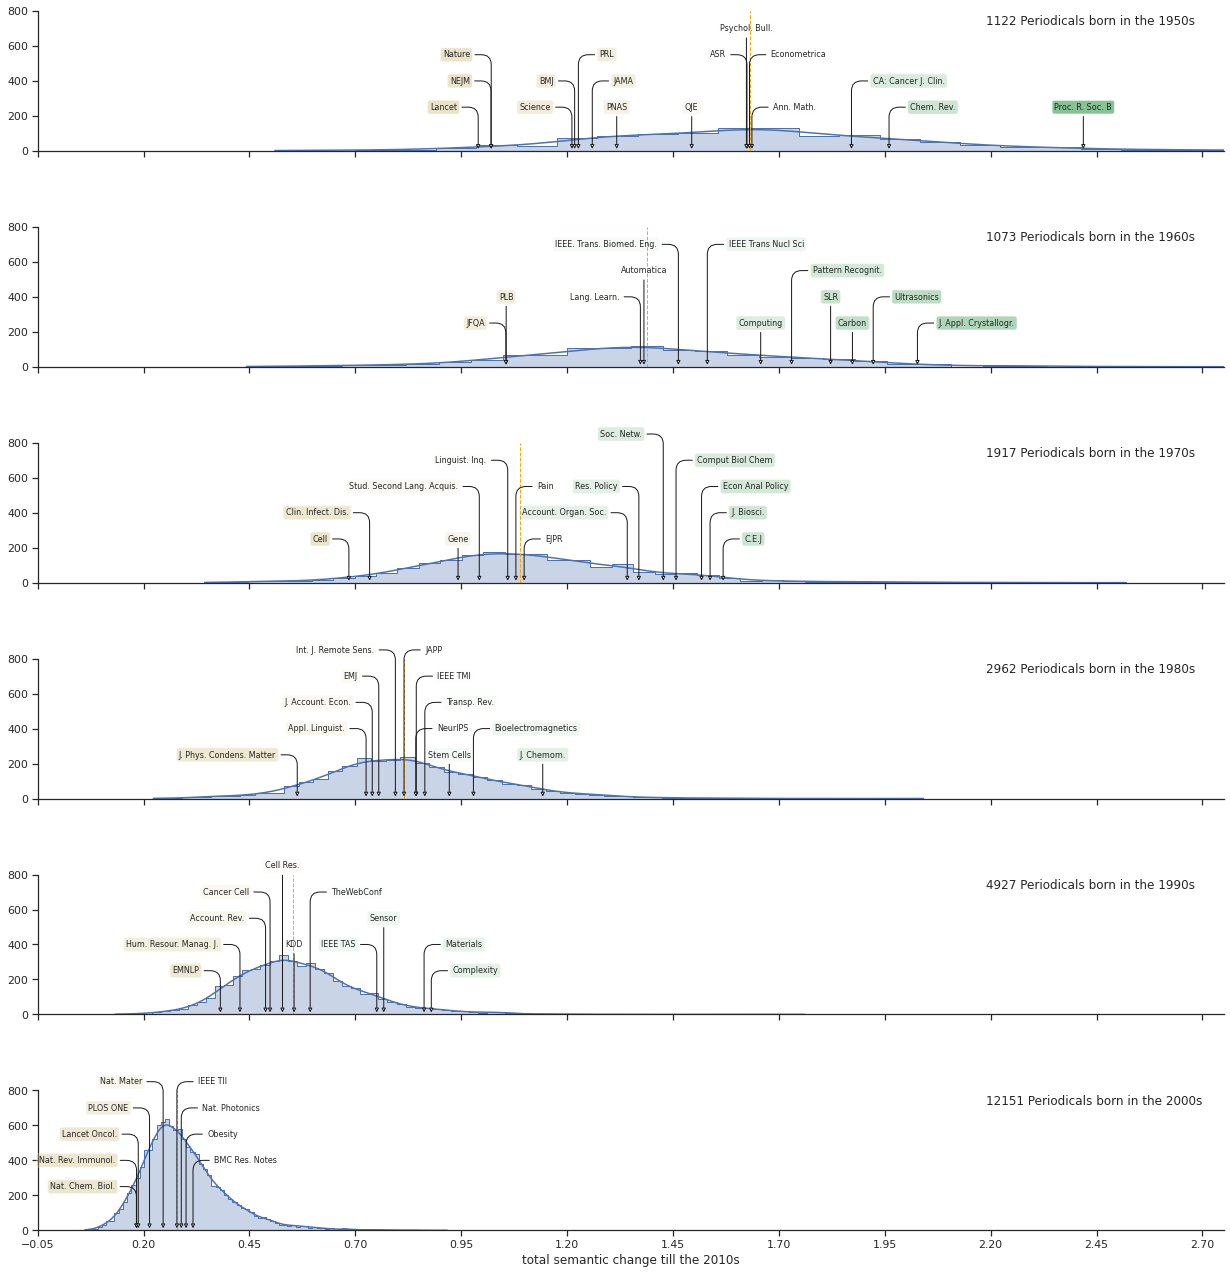

In [22]:
def annotate_n_and_decade(data, **kws):
    n = len(data)
    start_year = start_year_list[data.start_idx.unique()[0]]
    ax = plt.gca()
    ax.text(0.8, .9, f"{n} Periodicals born in the {start_year}s", transform=ax.transAxes)

def plot_median(x, **kwargs):
    ax = plt.gca()
    ax.axvline(x.median(), c='orange', ls='--', lw=1)

def annotate_periodical_name(data, opaque_value, **kwargs):
    selected_data = data[data.venue_name.isin(abbr_dict.keys())]
    display()
    ax = plt.gca()
    for index, row in selected_data.iterrows():
        TSC = row.total_semantic_change_2010s
        median = data.total_semantic_change_2010s.median()
        venue_name = row.venue_name

        if TSC <= median:
            c = 'y'
            alpha = (median - TSC) / median
        if TSC > median:
            c = 'g'
            alpha = (TSC - median) / (opaque_value - median)
        # ---------------------------adjust height---------------------------
        # low
        if venue_name in [# 1950s
                          'Psychological Bulletin', 'Proceedings of the National Academy of Sciences of the United States of America',
                          'Science', 'The Lancet', 
                          'Quarterly Journal of Economics', 'Annals of Mathematics', 'Chemical Reviews', 
                          'Philosophical Transactions of the Royal Society B', 'Journal of Applied Crystallography', 
                          # 1960s
                          'Carbon', 'Computing', 'Ultrasonics', 
                          'Journal of Financial and Quantitative Analysis',
                          'Atmosphere', 
                          # 1970s
                          'Cell', 'European Journal of Political Research', 
                          'Gene', 'Civil Engineering', 
                          # 1980s
                          'Journal of Chemometrics', 'Journal of Physics: Condensed Matter', 
                          'Stem Cells', 
                          # 1990s
                          'Complexity', 'empirical methods in natural language processing',
                          # 2000s
                          'Nature Chemical Biology', 
                         ]:
            label_y = 250

        # middle
        if venue_name in [# 1950s
                          'CA: A Cancer Journal for Clinicians', 'BMJ', 'JAMA', 
                          'The New England Journal of Medicine', 
                          # 1960s
                          'Language Learning', 'Ultrasonics', 'Stanford Law Review', 'Physics Letters B', 
                          # 1970s
                          'Journal of Biosciences', 'Clinical Infectious Diseases', 'Accounting Organizations and Society',
                          # 1980s
                          'Bioelectromagnetics', 'Applied Linguistics', 'neural information processing systems', 
                          # 1990s
                          'Human Resource Management Journal', 'IEEE Transactions on Applied Superconductivity', 'knowledge discovery and data mining',
                          'Materials', 
                          # 2000s
                          'Nature Reviews Immunology', 'BMC Research Notes', 
                          ]:
            label_y = 400
        # high
        if venue_name in [# 1950s
                          'Physical Review Letters', 'Econometrica', 'American Sociological Review', 'Nature', 
                          # 1960s
                          'Pattern Recognition', 'Automatica', 
                          # 1970s
                          'Life sciences in space research', 'Economic Analysis and Policy',
                          'Pain', 'Research Policy', 'Studies in Second Language Acquisition', 
                          # 1980s
                          'Transport Reviews', 'Journal of Accounting and Economics', 
                          # 1990s
                          'Cancer Cell', 'The Accounting Review', 'Sensors', 
                          # 2000s
                          'Lancet Oncology', 'Obesity', 
                         ]:
            label_y = 550

        # ultra high
        if venue_name in [# 1950s
                          'Psychological Bulletin', 
                          # 1960s
                          'IEEE Transactions on Biomedical Engineering', 'IEEE Transactions on Nuclear Science',
                          # 1970s
                          'Computational Biology and Chemistry', 'Linguistic Inquiry', 
                          # 1980s
                          'European Management Journal', 'IEEE Transactions on Medical Imaging',
                          # 1990s
                          'Cancer Cell', 'the web conference', 
                          # 2000s
                          'PLOS ONE', 'Nature Photonics', 
                          ]:
            label_y = 700

        # max high
        if venue_name in [# 1950s
                          
                          # 1960s
                          
                          # 1970s
                          'Social Networks', 
                          # 1980s
                          'International Journal of Remote Sensing', 'Journal of Accounting and Public Policy', 
                          # 1990s
                          'Cell Research', 
                          # 2000s
                          'Nature Materials', 'IEEE Transactions on Industrial Informatics', 
                          ]:
            label_y = 850
            
        # ---------------------------adjust arrow direction---------------------------
        # straight arrow
        if venue_name in [# 1950s
                          'Proceedings of the National Academy of Sciences of the United States of America',
                          'Quarterly Journal of Economics', 'Psychological Bulletin',  
                          # 1960s
                          'Carbon', 'Stanford Law Review', 'Computing', 
                          'Physics Letters B', 'Automatica',
                          # 1970s
                          'Gene', 
                          # 1980s
                          'Journal of Chemometrics', 
                          'Stem Cells', 
                          # 1990s
                          'knowledge discovery and data mining', 'Sensors', 'Cell Research', 
                         # 2000s
                          'Philosophical Transactions of the Royal Society B',
                         ]:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.", fc="w", color='k')
            label_x = TSC
            haligh = 'center'

        # bend arrow
        else:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="angle,angleA=0,angleB=-90,rad=10", fc="w", color='k')
            # bend right
            if venue_name in [# 1950s
                              'Proceedings of the National Academy of Sciences of the United States of America', 'JAMA',
                              'The New England Journal of Medicine', 'CA: A Cancer Journal for Clinicians', 
                              'Chemical Reviews', 'Econometrica', 'Annals of Mathematics', 'Physical Review Letters', 
                              # 1960s
                              'Journal of Applied Crystallography', 'Pattern Recognition', 'IEEE Transactions on Nuclear Science', 'Ultrasonics', 
                              # 1970s
                              'European Journal of Political Research', 'Pain', 
                              'Economic Analysis and Policy', 'Life sciences in space research', 'Civil Engineering', 'Journal of Biosciences', 
                              'Computational Biology and Chemistry', 
                              # 1980s
                              'Transport Reviews', 'Bioelectromagnetics', 'Journal of Accounting and Public Policy', 
                              'IEEE Transactions on Medical Imaging', 'neural information processing systems', 
                              # 1990s
                              'the web conference', 'Complexity', 'Materials', 
                              # 2000s
                              'Obesity', 'IEEE Transactions on Industrial Informatics', 'BMC Research Notes', 'Nature Photonics', 
                             ]:
                label_x = TSC + 0.05
                haligh = 'left'
            # bend left
            if venue_name in [# 1950s
                              'Science', 'BMJ', 'The Lancet', 'Journal of Financial and Quantitative Analysis', 
                              'The New England Journal of Medicine', 'Nature', 'American Sociological Review', 
                              # 1960s
                              'Atmosphere', 'Language Learning', 'IEEE Transactions on Biomedical Engineering', 
                              # 1970s
                              'Linguistic Inquiry', 'Studies in Second Language Acquisition', 'Cell', 'Clinical Infectious Diseases', 
                              'Research Policy', 'Accounting Organizations and Society', 'Social Networks',
                              # 1980s
                              'Applied Linguistics', 'Journal of Accounting and Economics', 'European Management Journal', 
                              'Journal of Physics: Condensed Matter', 
                              'International Journal of Remote Sensing', 
                             # 1990s
                              'The Accounting Review', 'Human Resource Management Journal', 'empirical methods in natural language processing',
                              'Cancer Cell', 'IEEE Transactions on Applied Superconductivity', 
                             # 2000s
                              'Nature Reviews Immunology', 'Nature Materials', 'Lancet Oncology', 'Nature Chemical Biology', 'PLOS ONE', 
                              
            ]: 
                label_x = TSC - 0.05
                haligh = 'right'

        bbox_props = dict(boxstyle="round", fc=c, ec="1", alpha=alpha)
        ax.annotate(abbr_dict[venue_name], xy=(TSC, 0), xytext=(label_x, label_y), ha=haligh, va="center",
                    size=8, bbox = bbox_props, arrowprops = arrow_props)


plt.figure(dpi=300)
sns.set(style='white', font_scale=1)
g2 = sns.FacetGrid(global_semantic_change_df, row="start_idx", height=3, aspect=6, margin_titles=True)

g2.map_dataframe(sns.histplot, x="total_semantic_change_2010s", kde=True, element='step', alpha=0.3)
g2.map(plot_median, 'total_semantic_change_2010s')
g2.map_dataframe(annotate_n_and_decade)
g2.map_dataframe(annotate_periodical_name, data=global_semantic_change_df, opaque_value=2.75)

for ax in g2.axes.flatten():
    ax.set_ylabel('')
g2.set_titles(row_template='')
g2.set_xlabels('total semantic change till the 2010s')
g2.tick_params(axis='both', bottom='on',left='on')
g2.set(xlim=(-0.05, 2.75), xticks=np.arange(-0.05, 2.75, 0.25), yticks=np.arange(0, 1000, 200))

plt.show()

In [23]:
g2.savefig('total_global_semantic_change.pdf', 
          dpi = 300, 
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')

# Aggregate total local semantic change into discipline level 

<Figure size 1800x1200 with 0 Axes>

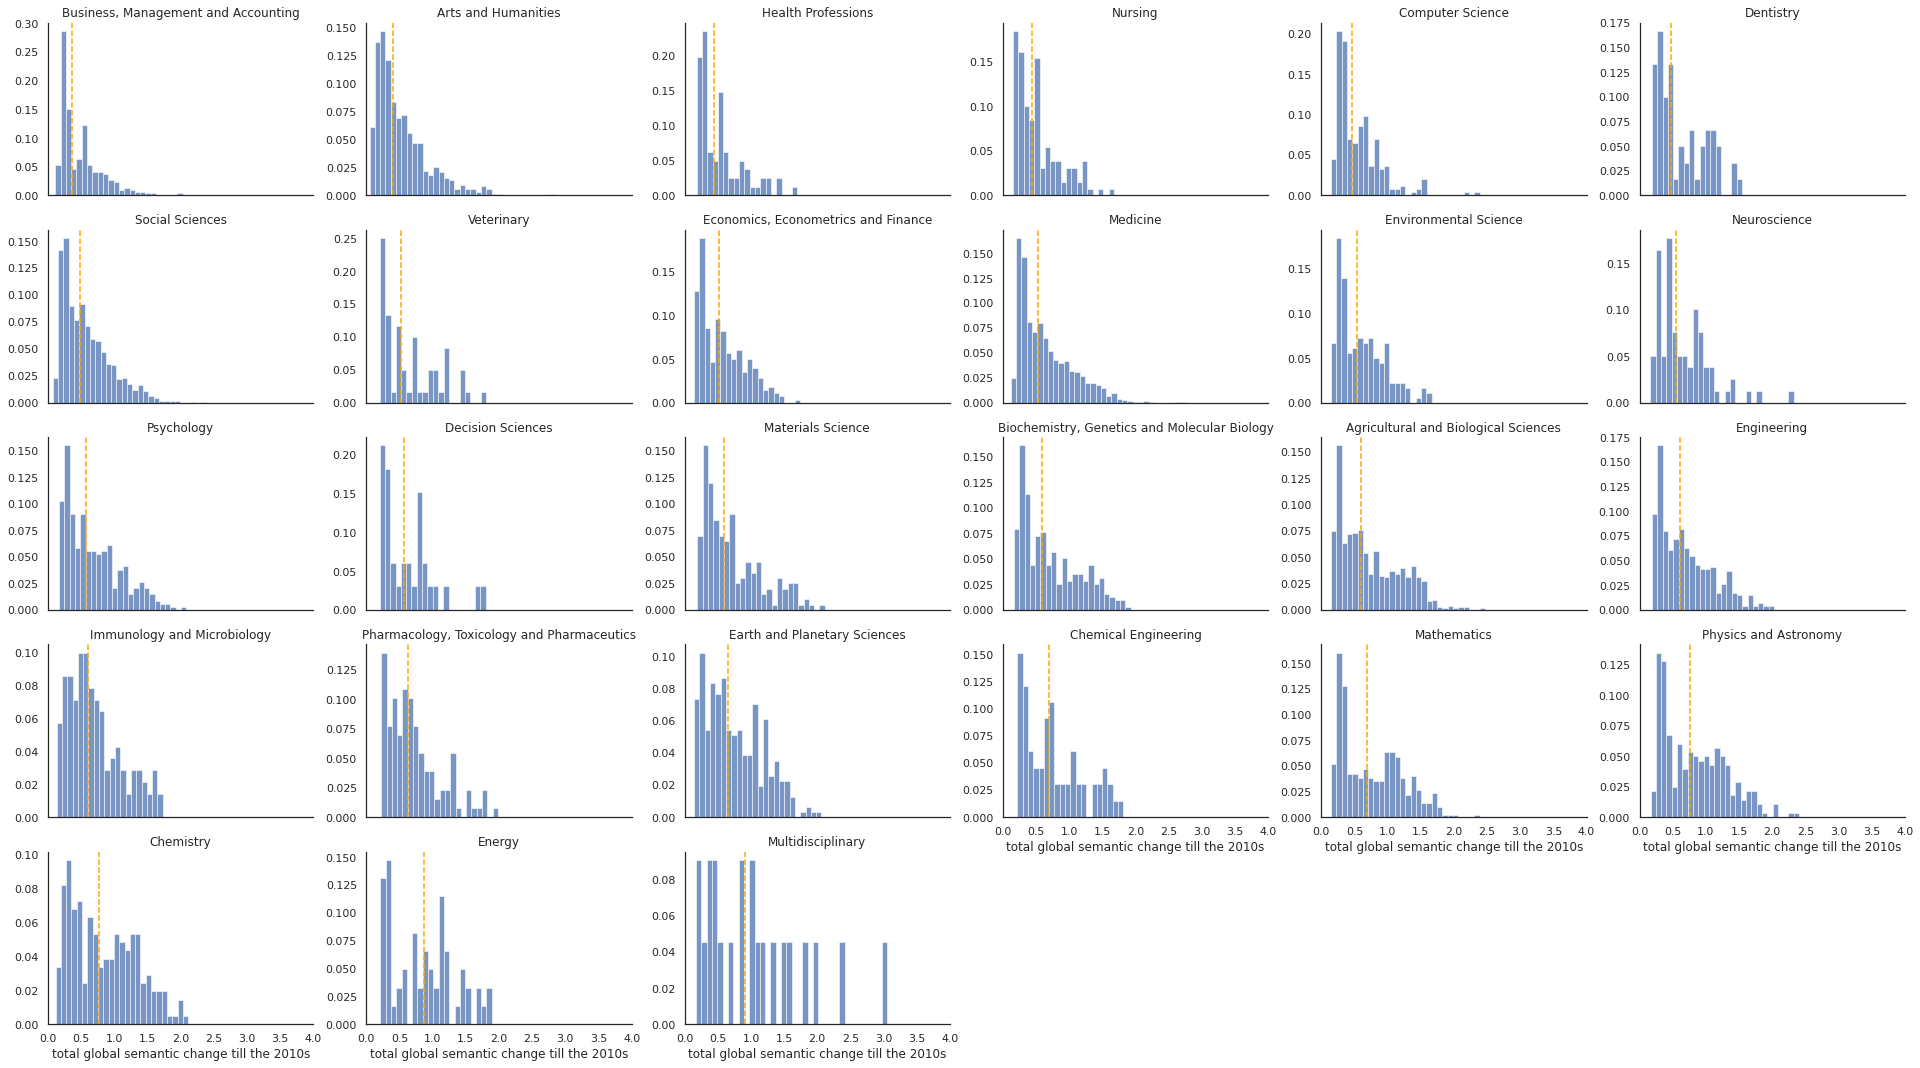

In [30]:
col_name = 'total_semantic_change_2000s'

def plot_median(x, **kwargs):
    plt.axvline(x.median(), c='orange', ls='--', lw=1.5)
    
plt.figure(dpi=300)
sns.set(style='white', font_scale=1)
g3 = sns.FacetGrid(data=global_semantic_change_df, col='scopus_label', 
                  col_wrap=6, aspect=1.5, xlim=(0.0, 4), sharey=False,
                  col_order=global_semantic_change_df.groupby('scopus_label').agg({col_name:'median'}).sort_values(by=col_name).index.to_list()
                 )
g3.map(sns.histplot, col_name, stat='probability', binwidth=0.08, edgecolor=None)
g3.map(plot_median, col_name)
g3.set_titles(col_template='{col_name}',row_template=" ")
g3.set_xlabels('total global semantic change till the 2010s')
g3.figure.subplots_adjust(wspace=0.2, hspace=0.2)
for ax in g3.axes.flatten():
    ax.set_ylabel('')
    # ax.set_yticks([])
plt.show()

In [31]:
g3.savefig('total_global_semantic_change_by_discipline.pdf', 
          dpi = 300, 
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')